In [1]:
import pandas as pd
import numpy as np
from scanpy import read_h5ad
from tqdm.notebook import tqdm
import torch
%pylab inline
torch.cuda.set_device(4)

In [2]:
x = read_h5ad('../data/topcoder/sc_training.h5ad')
condition_groups = x.obs.groupby('condition').groups
xdf = x.to_df()

group_tensor = {k:torch.tensor(xdf.loc[v].values, dtype = torch.float,device = 'cuda') for k,v in condition_groups.items()}
group_output = {}

for gene in tqdm(condition_groups.keys()):
    group_output[gene] = torch.tensor(x.obs['state'].loc[condition_groups[gene]].value_counts(normalize = True).sort_index().values,dtype = torch.float, device = 'cuda')

  0%|          | 0/67 [00:00<?, ?it/s]

In [3]:

np.random.seed(123)
gene_names = [a for a in condition_groups if a!='Unperturbed']
np.random.shuffle(gene_names)

train = gene_names[:50]
val = gene_names[50:60]
test = gene_names[60:]


ytr = torch.stack([group_output[k] for k in train])
yval = torch.stack([group_output[k] for k in val])



seq_batch = torch.from_numpy(np.load('topcoder_gene_seq_features.npy')).cuda()
ind_key = {k:i for i,k in enumerate(np.load('topcoder_gene_names.npy'))}
seq_tr = seq_batch[[ind_key[g] for g in train]]
seq_val = seq_batch[[ind_key[g] for g in val]]
seq_test = seq_batch[[ind_key[g] for g in test]]



In [12]:
from torch import nn
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

class BinModLinear(nn.Module):
    def __init__(self, n_mod,samp_max = 50,n_v = 20):
        super(BinModLinear, self).__init__()
        self.n_mod = n_mod
        self.n_v = n_v
        self.samp_max = samp_max

        self.gex_p1 = nn.Sequential(nn.Linear(xdf.shape[1],10),nn.Tanh())
        self.gex_q = nn.Linear(10, 10*5,bias = False)
        self.gex_v = nn.Linear(10, n_mod) 

        self.Q_k = nn.Sequential(nn.Linear(5,128), nn.ReLU(), nn.Linear(128,128), nn.ReLU(), nn.Linear(128, n_mod*n_v))
        self.Q_val = nn.Sequential(nn.Linear(5,128), nn.ReLU(), nn.Linear(128,128), nn.ReLU(), nn.Linear(128, n_v))
        self.mapper = nn.Sequential(nn.Linear(n_v, 128), nn.ReLU(), nn.Linear(128,1), nn.Tanh())

    def forward(self,klist,targets):
        q1 = torch.stack([self.gex_p1(group_tensor[k][np.random.randint(group_tensor[k].shape[0], size = np.random.randint(5,self.samp_max))]).mean(axis = 0) for k in klist])
        q2 = self.gex_q(q1).reshape(-1, 10,5)
        v  =self.gex_v(q1) 
        q = torch.softmax((q2*q1[:,:,None]).sum(axis = 1), dim = -1)*v
        
        k = self.Q_k(targets).reshape(-1, self.n_mod,self.n_v ) 
        attn = torch.softmax((q[:,:,None]*k).sum(axis = 1), -1)
        
        val = self.Q_val(targets)
        
        out = 1+self.mapper(attn*val)
        
    
        return out.flatten(),q
        
        

  0%|          | 0/200000 [00:00<?, ?it/s]

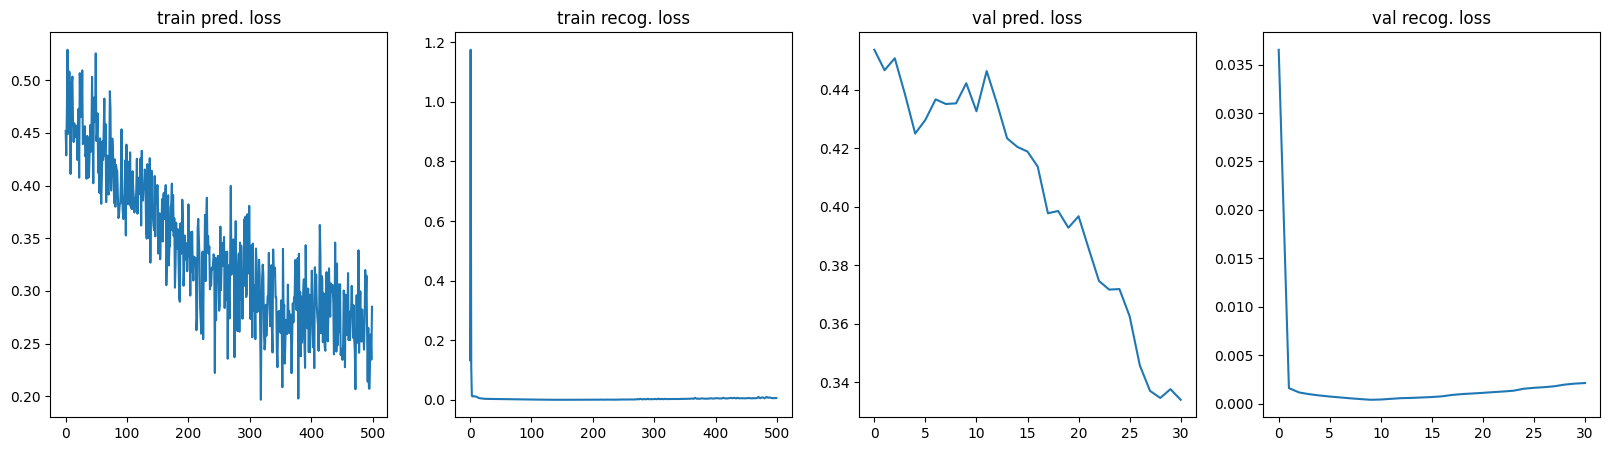

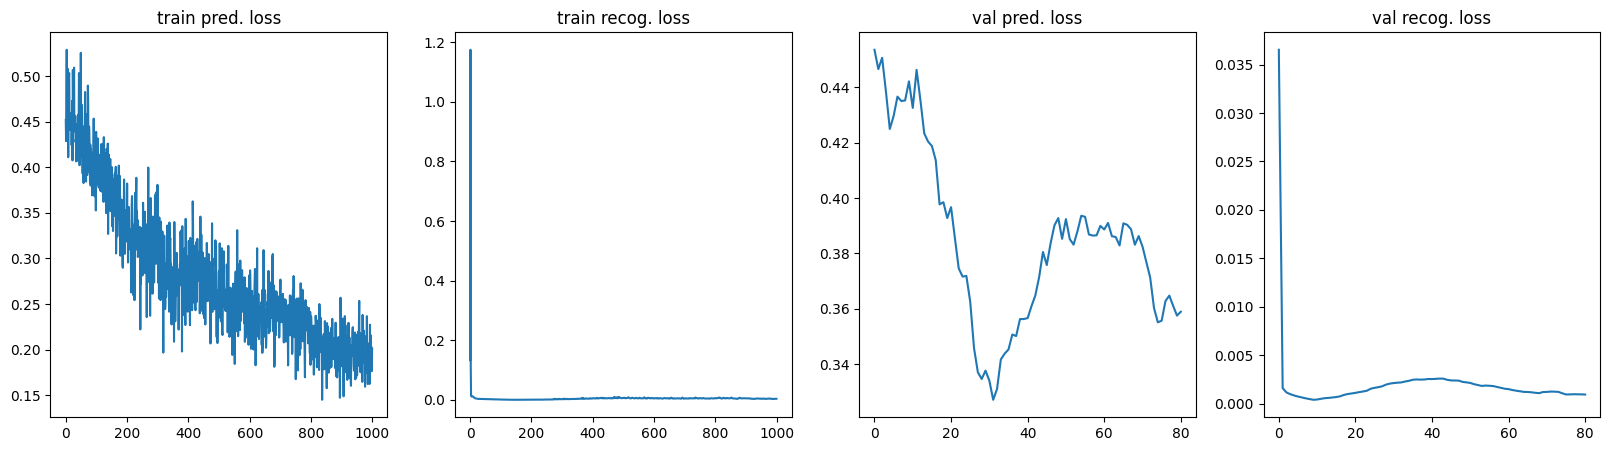

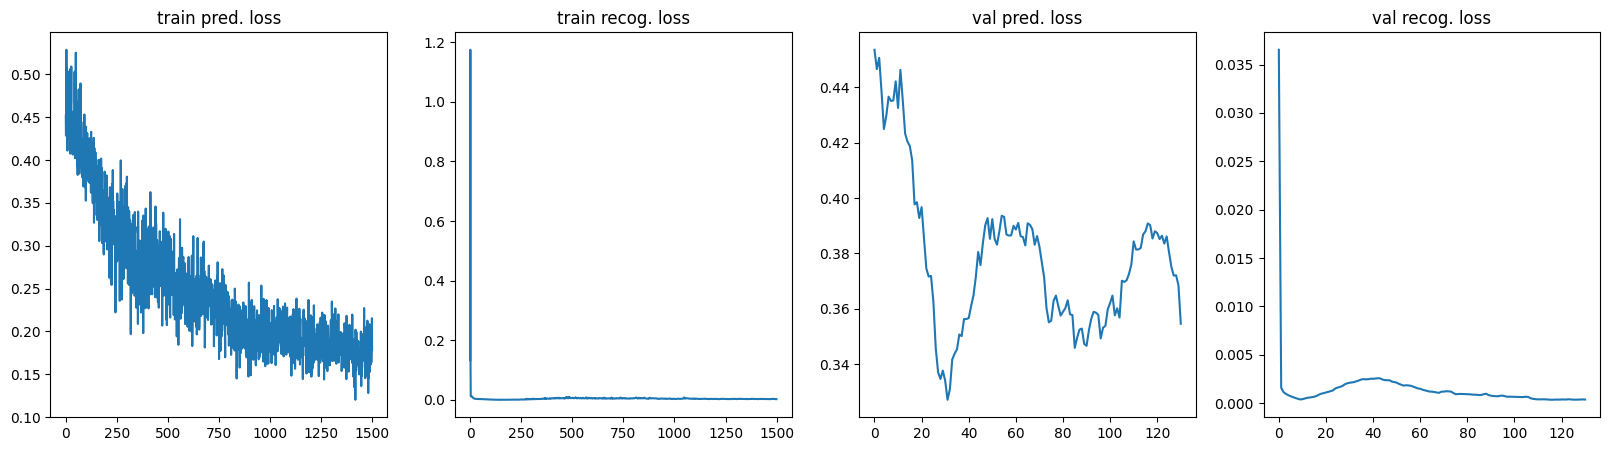

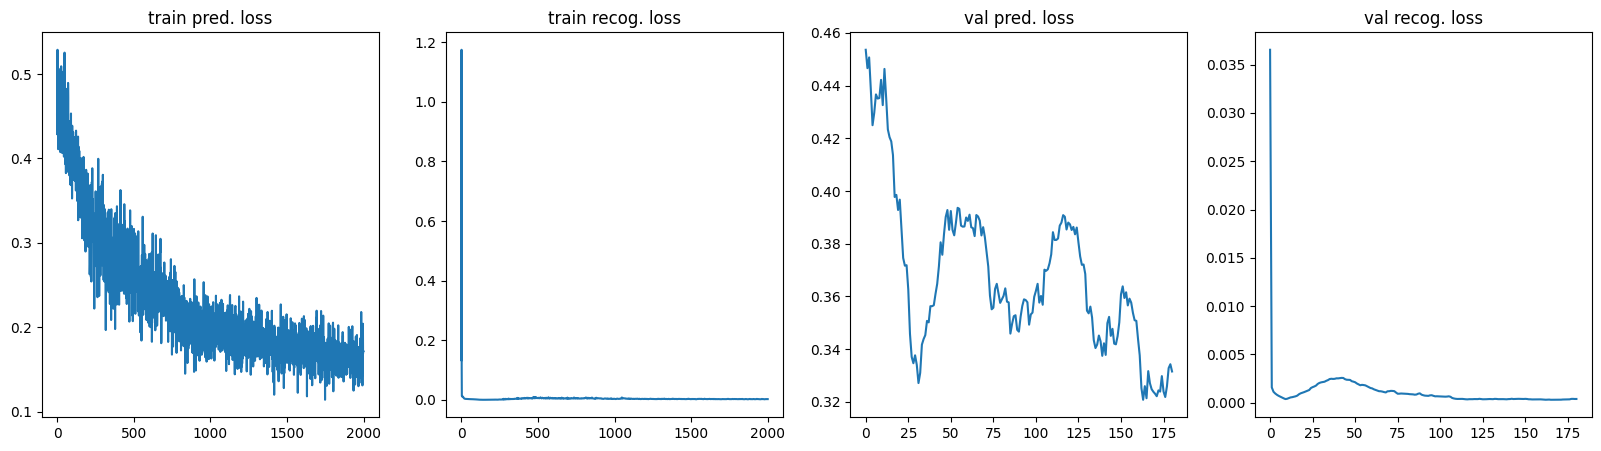

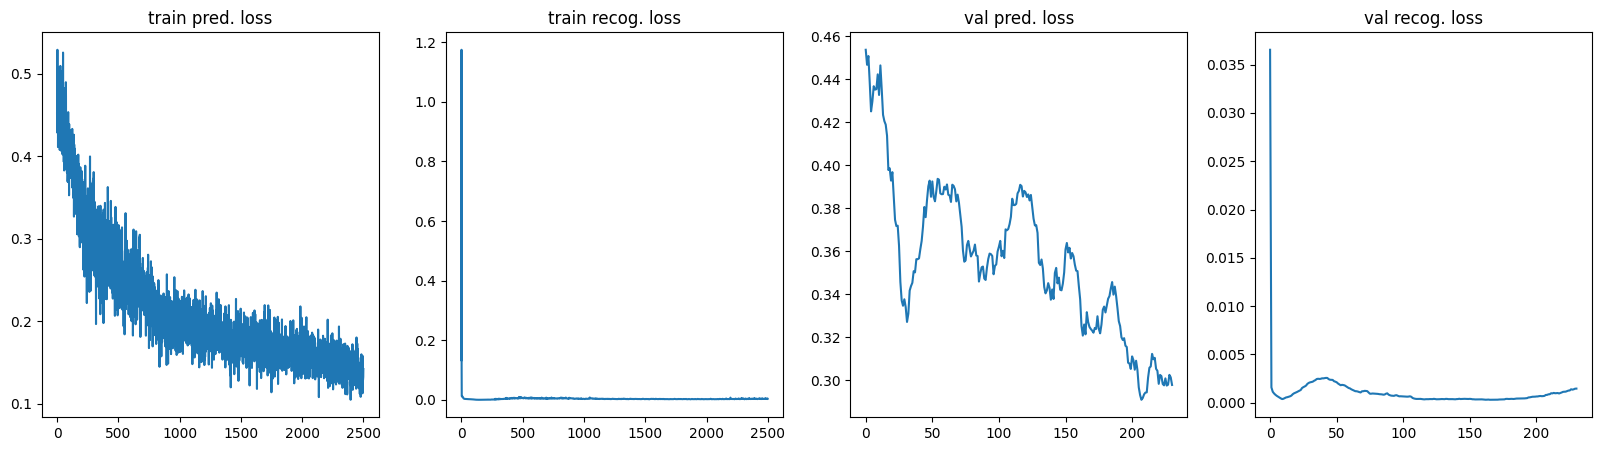

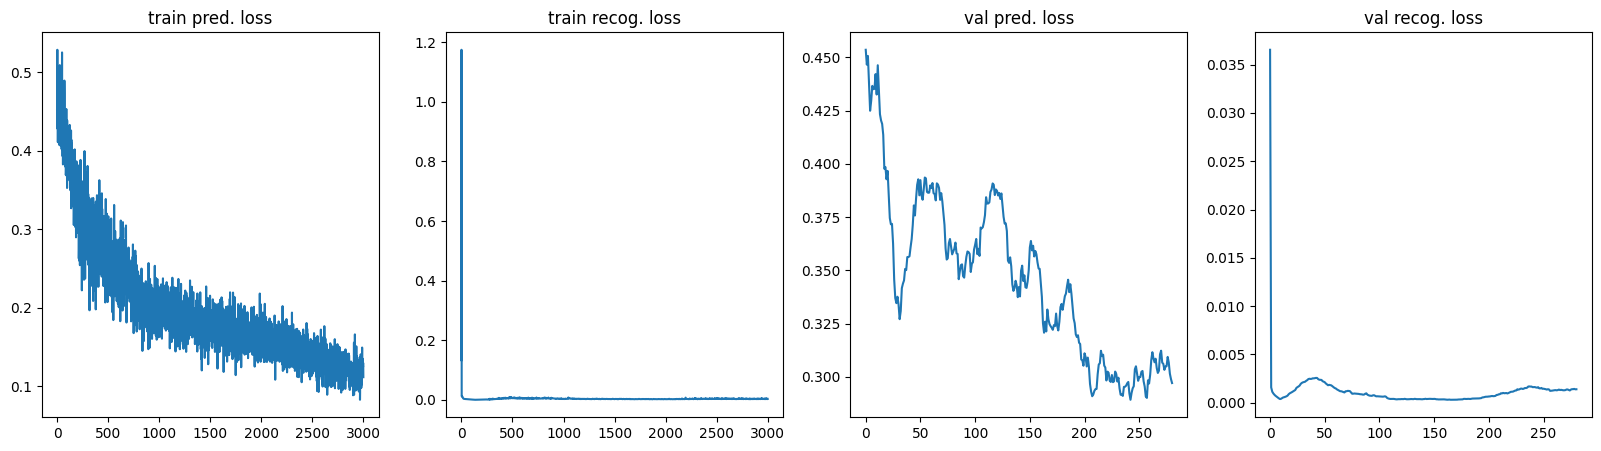

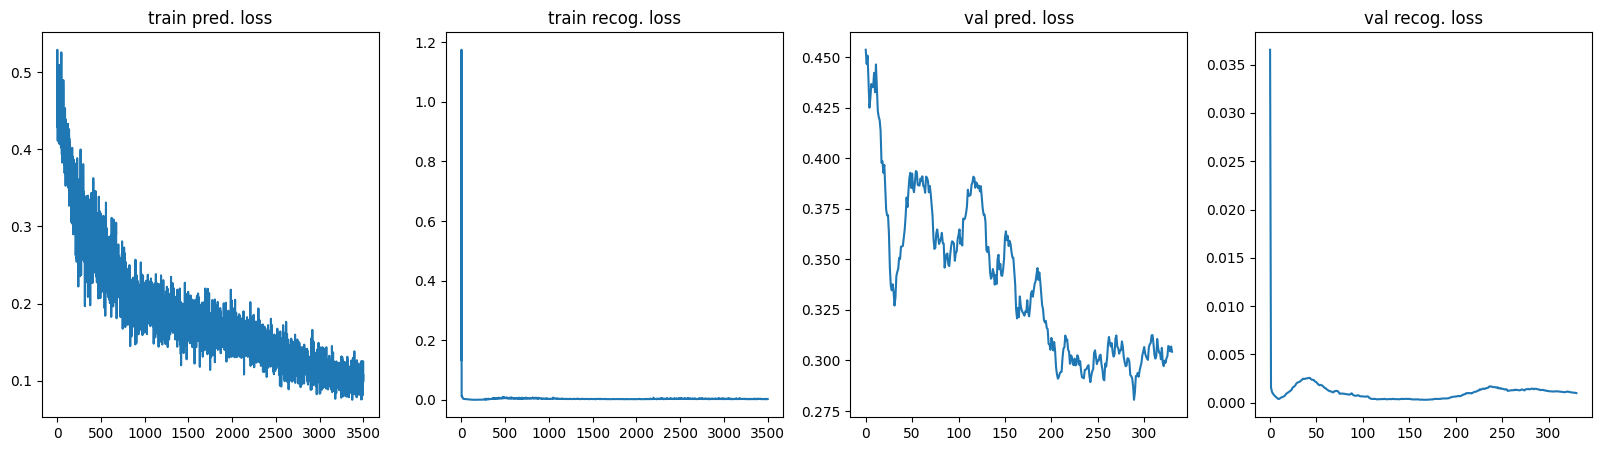

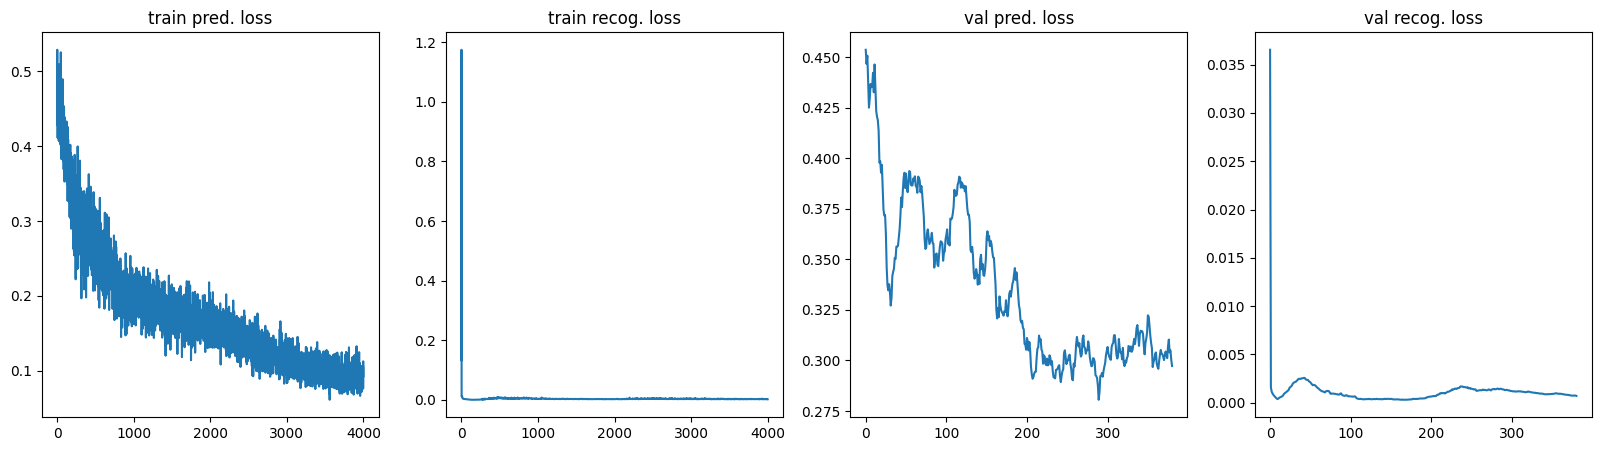

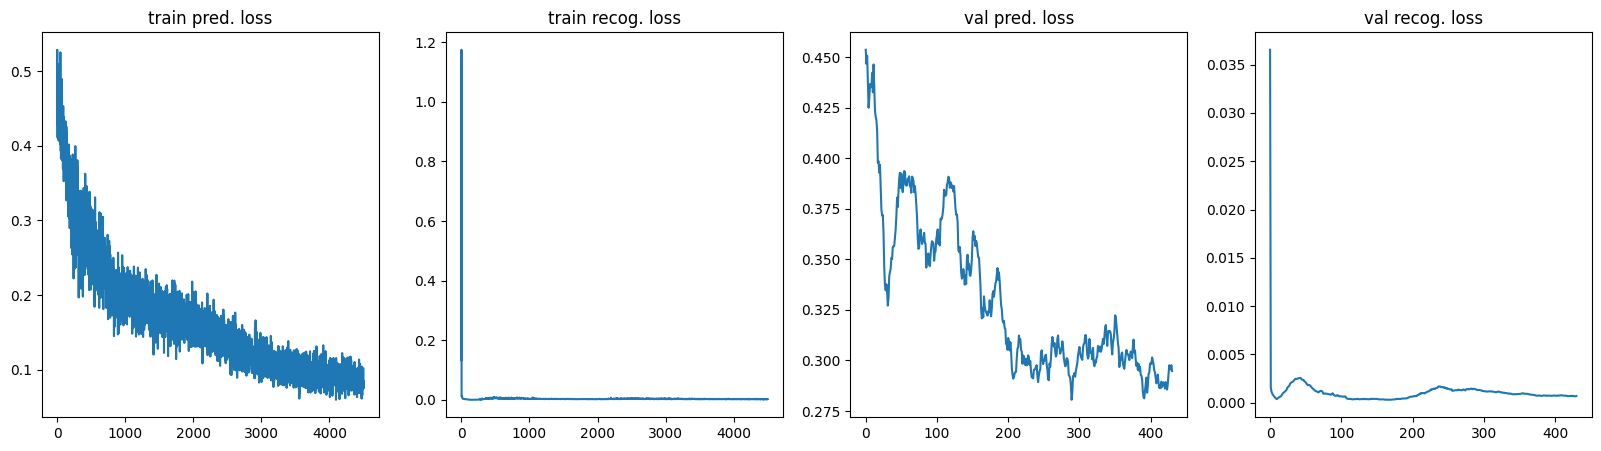

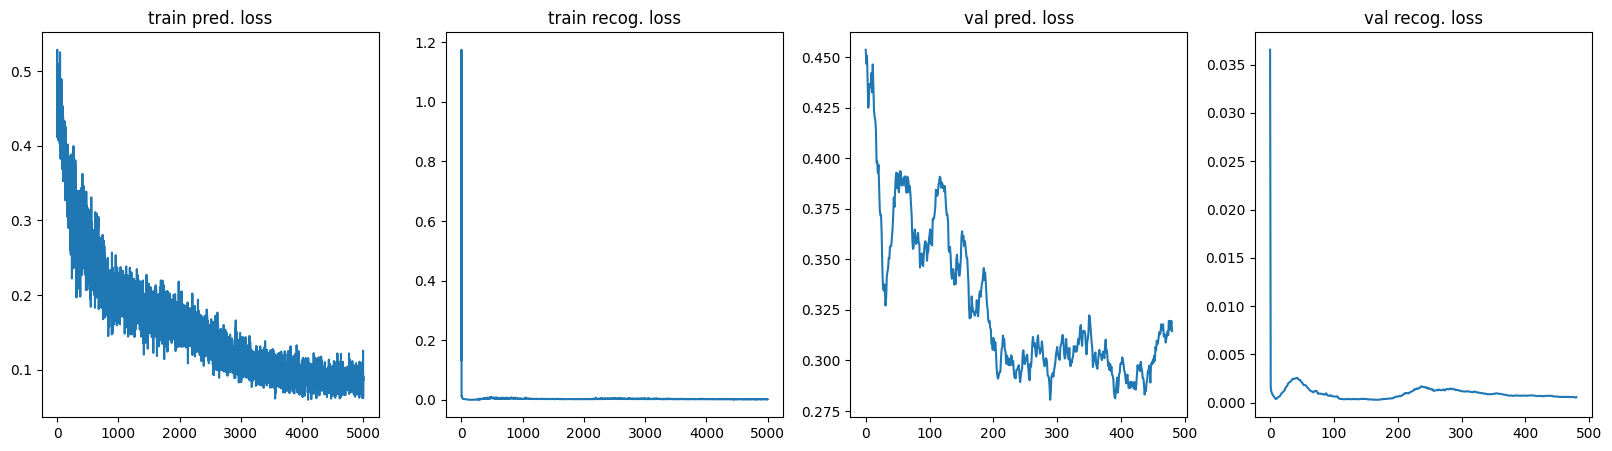

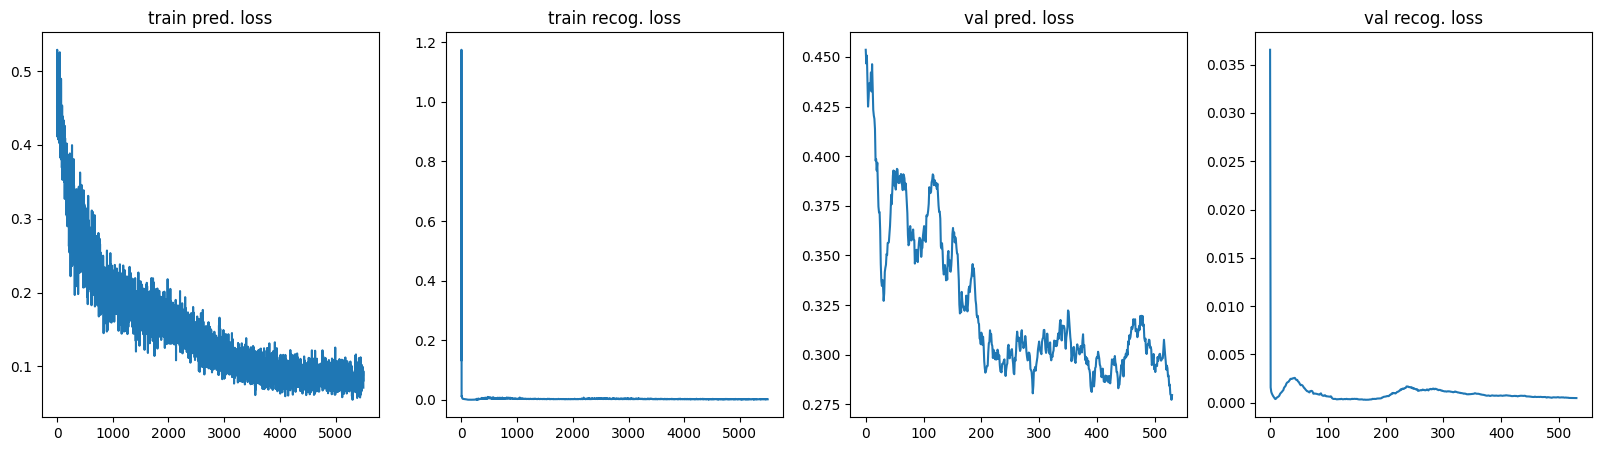

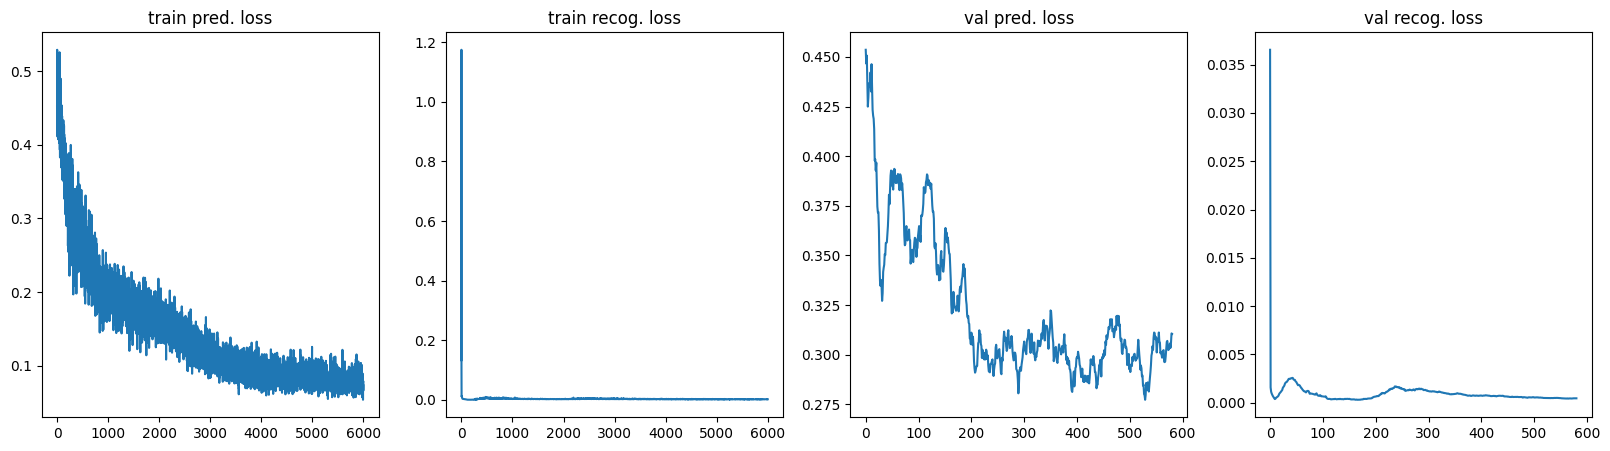

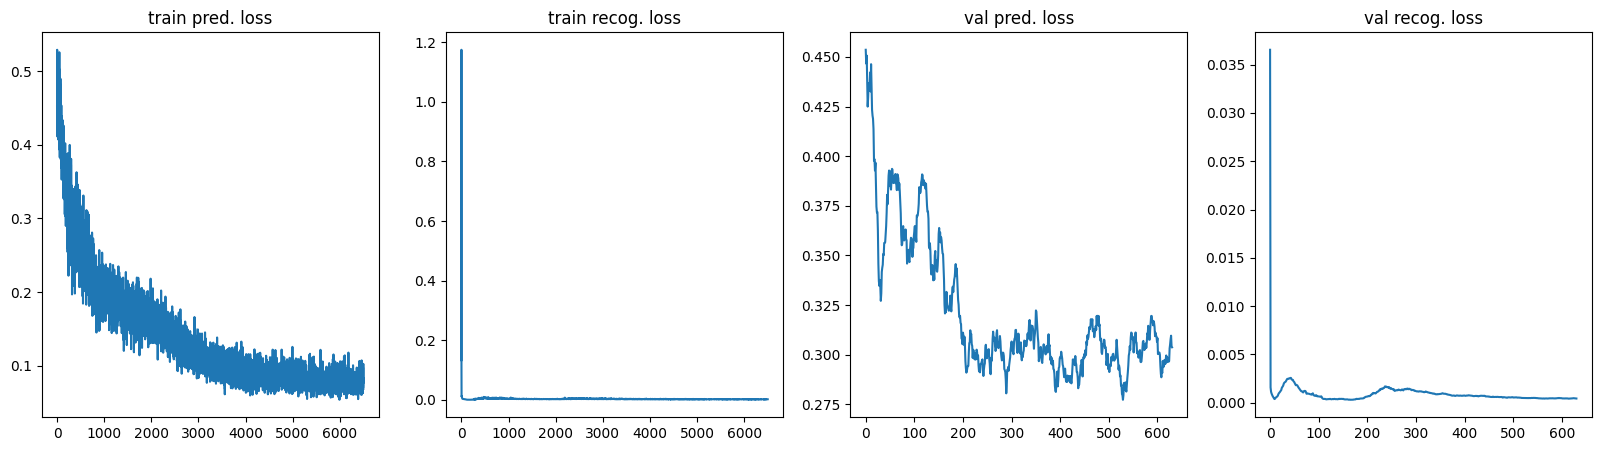

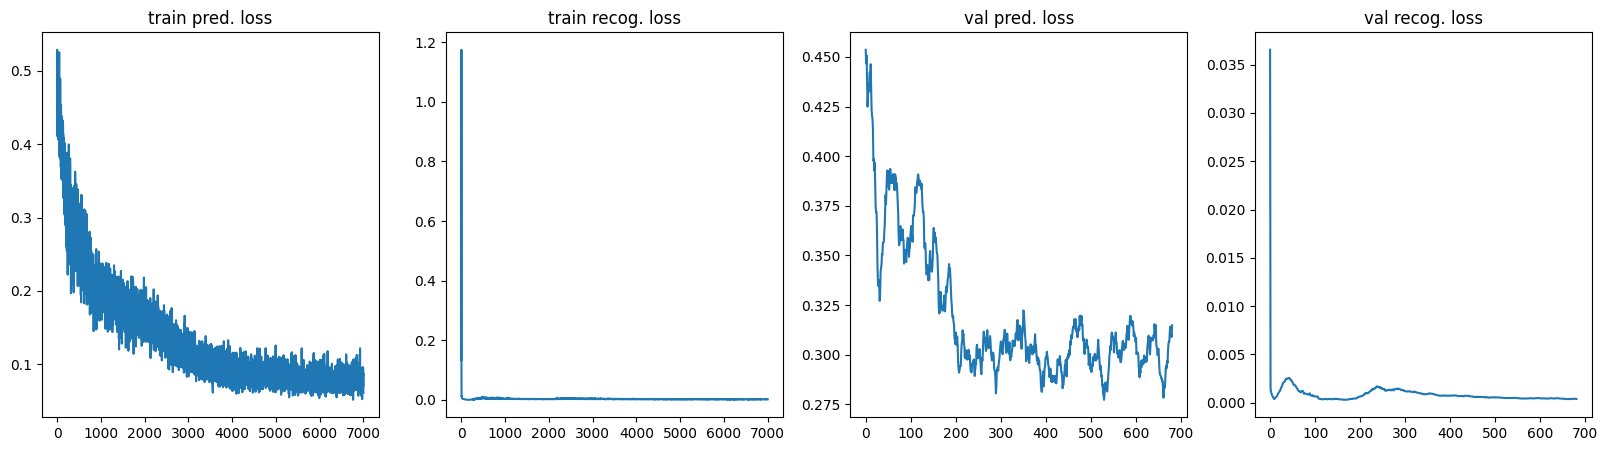

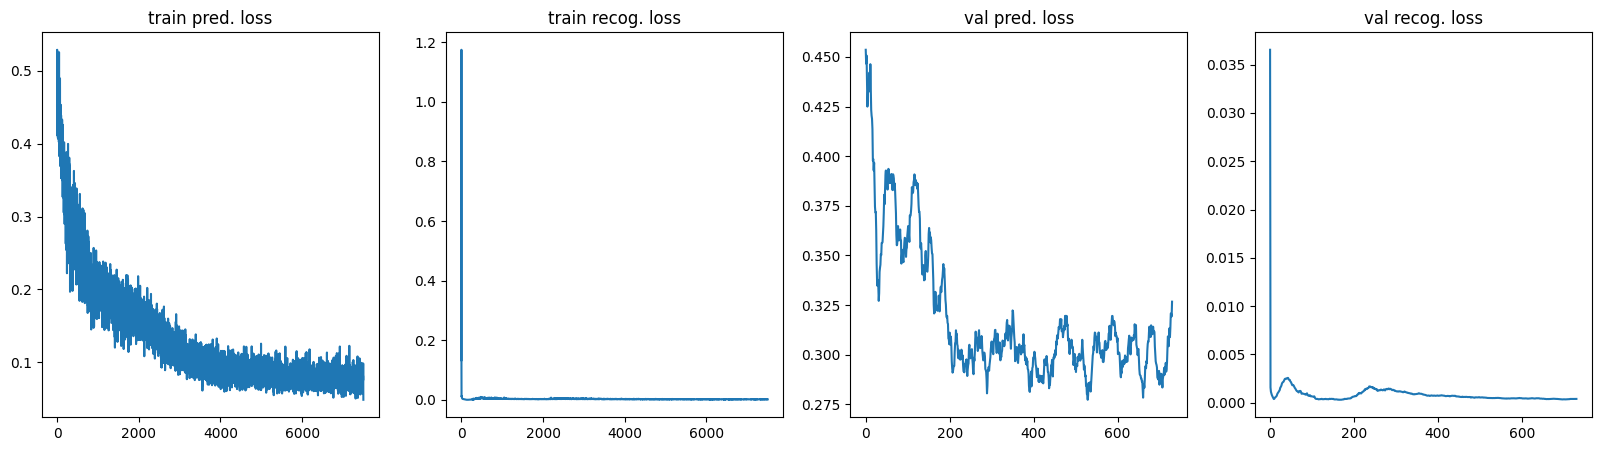

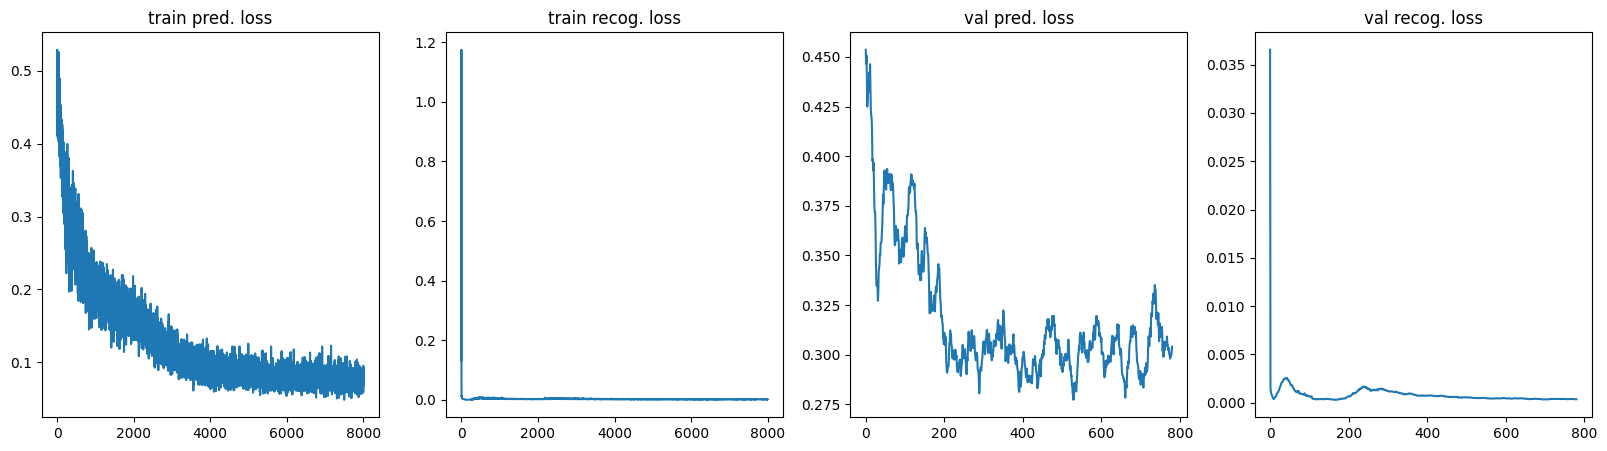

KeyboardInterrupt: 

In [15]:
figsize(20,5)
n_mod = 5
binmod = BinModLinear(n_mod = n_mod).cuda()
conv = nn.Sequential(nn.Dropout(0.5),nn.Conv1d(384,512,20,5), nn.ReLU(), nn.MaxPool1d(2),nn.Conv1d(512,20,10),nn.ReLU(), nn.Flatten(),nn.Linear(180,n_mod)).cuda()

optim = torch.optim.AdamW(list(binmod.parameters()) + list(conv.parameters()), lr = 1e-4,weight_decay = 0.0001)

loss_history = []
val_loss_history = []
spred_loss_history = []
val_s_history = []


for i in tqdm(range(200000)):
    targets = ytr[np.random.choice(np.arange(ytr.shape[0]),size = ytr.shape[0])] + 0.05*torch.rand_like(ytr)
    targets/=targets.sum(axis = 1,keepdims = True)
    dists = (torch.abs(ytr-targets)).sum(axis = 1)
    pred,q = binmod.forward(train,targets)
    
    loss = torch.abs(dists - pred ).mean()    
    
    spred = conv.forward(seq_tr)
    spredloss = torch.square(spred -q ).sum(axis = 1).mean()
    
    
    optim.zero_grad()
    (loss + spredloss).backward()
    optim.step()
    loss_history.append(loss.detach().cpu().numpy())
    spred_loss_history.append(spredloss.detach().cpu().numpy())
    
    if i%10==0:
        val_targets = yval[np.random.choice(np.arange(yval.shape[0]),size = yval.shape[0])]
        binmod.eval()
        conv.eval()
        val_pred,val_q = binmod.forward(val,val_targets)
        val_s_loss = torch.square(val_q - conv(seq_val)).sum(axis = 1).mean()
        val_dists = (torch.abs(yval-val_targets)).sum(axis = 1)
        val_loss = torch.abs(val_pred-val_dists).mean()
        val_loss_history.append(val_loss.detach().cpu().numpy())
        val_s_history.append(val_s_loss.detach().cpu().numpy())
        conv.train()
        binmod.train()

    if (i+1) %500 ==0:
        plt.subplot(1,4,1)
        plt.plot(loss_history)
        plt.title('train pred. loss')
        plt.subplot(1,4,2)
        plt.plot(spred_loss_history)
        plt.title('train recog. loss')
        plt.subplot(1,4,3)
        plt.plot(moving_average(val_loss_history,20))
        plt.title('val pred. loss')
        plt.subplot(1,4,4)
        plt.plot(moving_average(val_s_history,20))
        plt.title('val recog. loss')

        plt.show()
        
        # ANNEAL THE NUMBER OF SAMPLES
        binmod.samp_max -=1
        binmod.samp_max = max(3,binmod.samp_max-1)
        
torch.save({'binmod': binmod.state_dict(), 'conv': conv.state_dict()}, 'topcoder_model_state_dict')

  0%|          | 0/200000 [00:00<?, ?it/s]

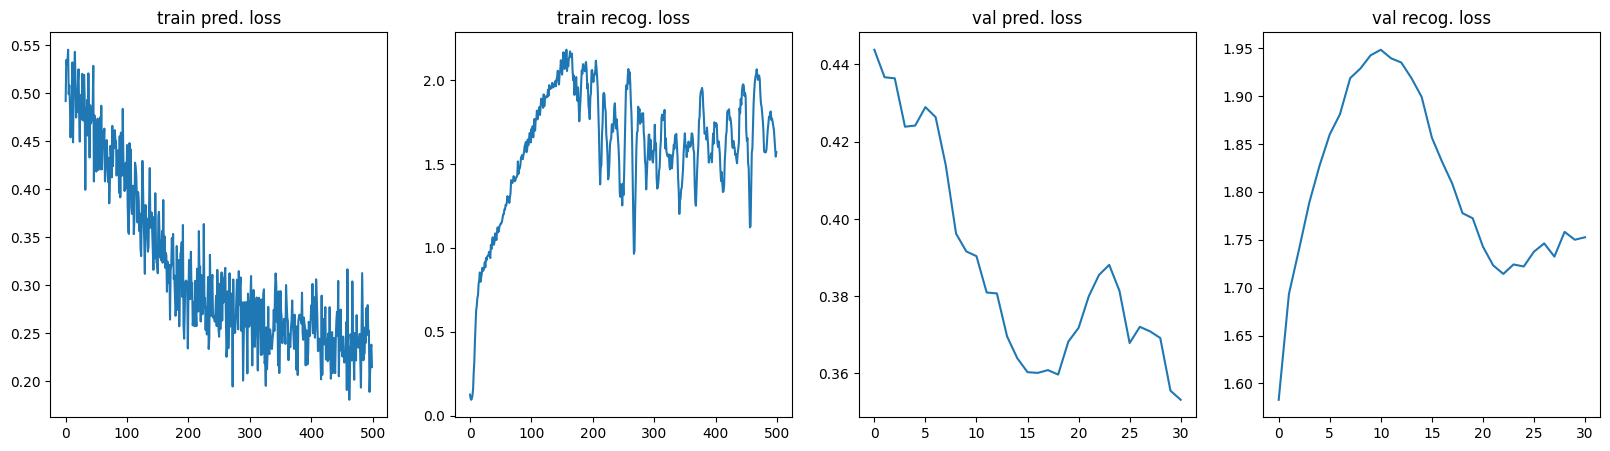

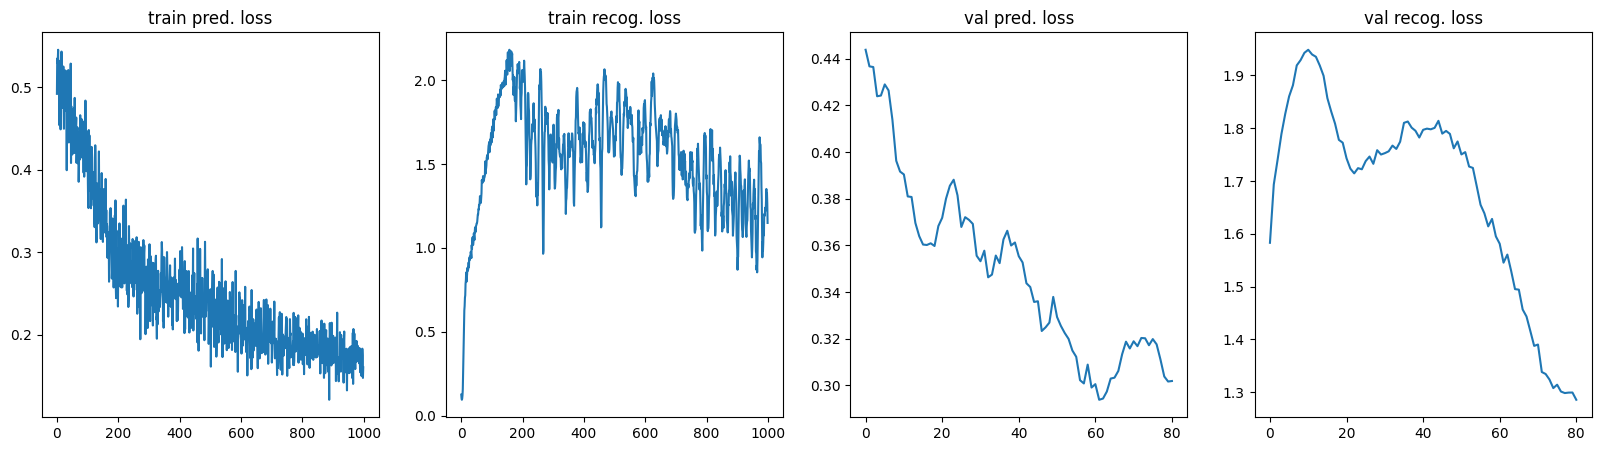

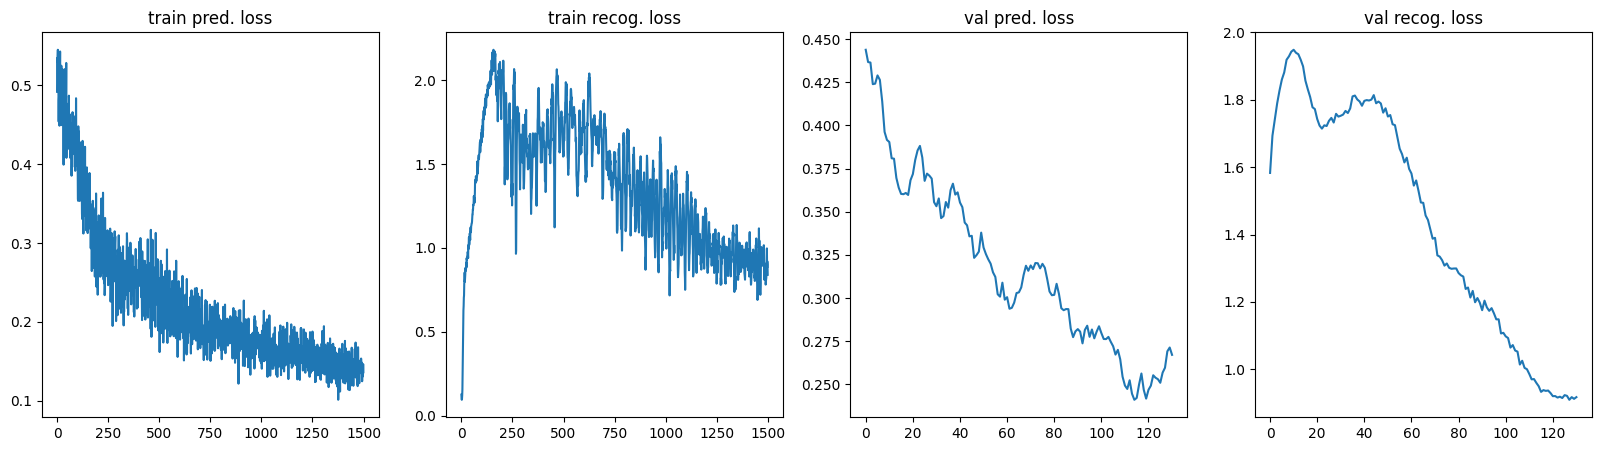

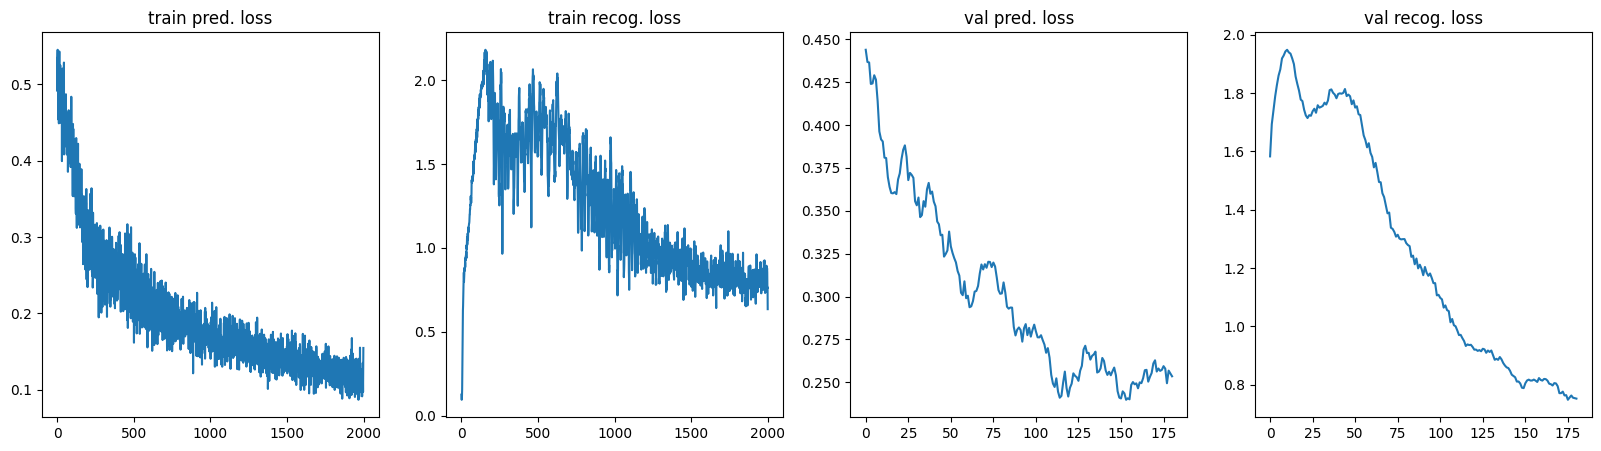

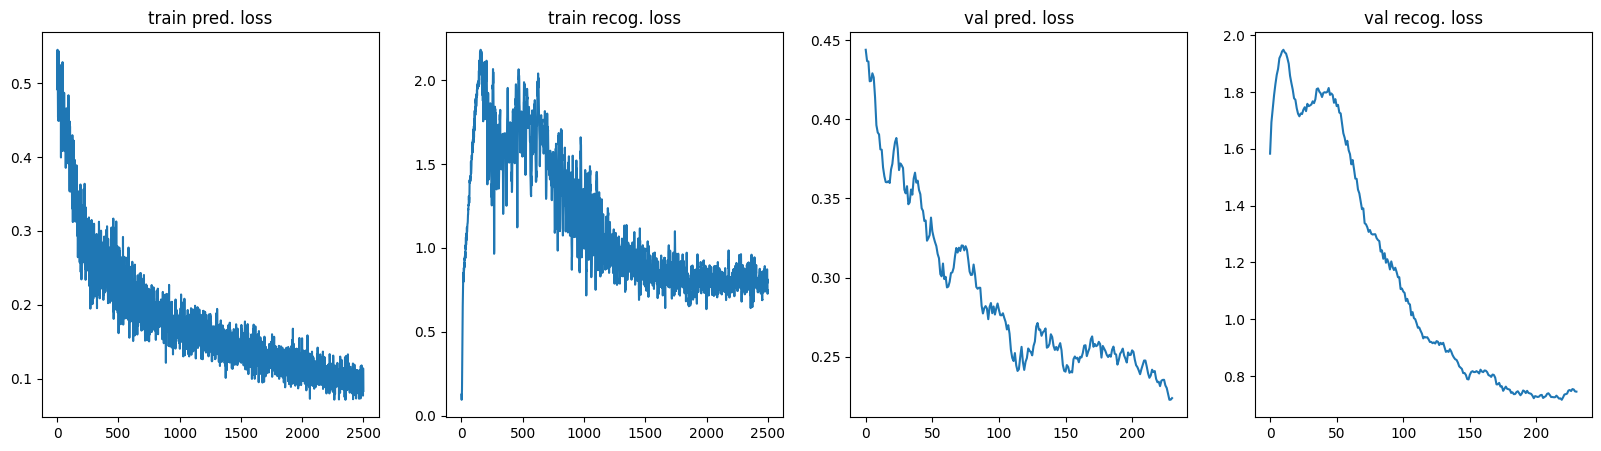

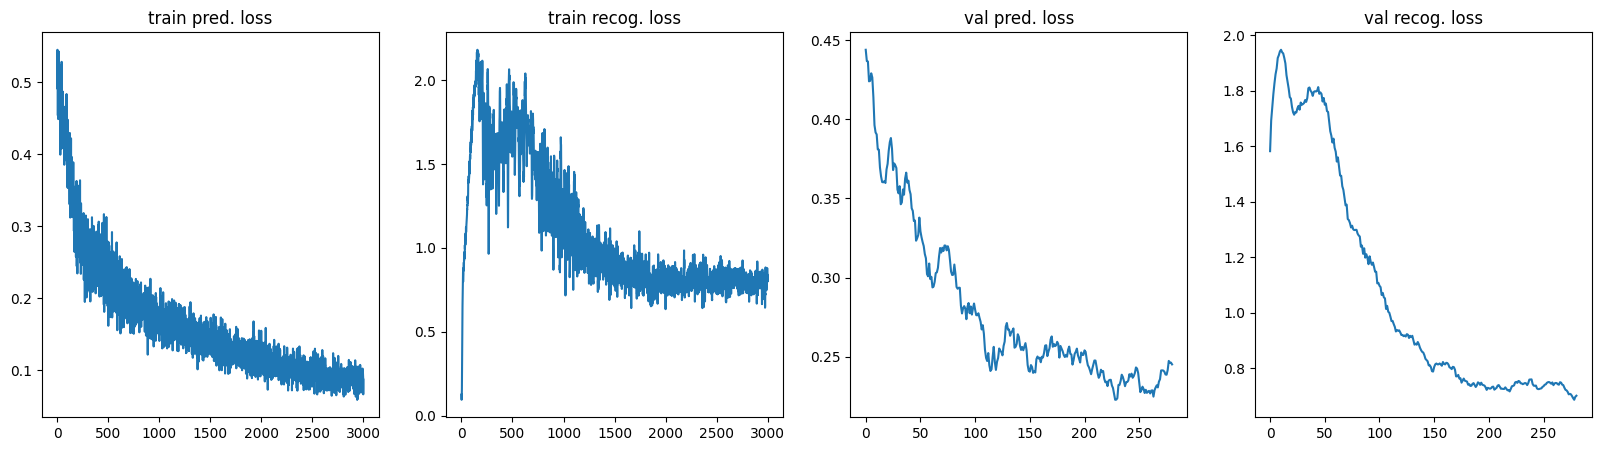

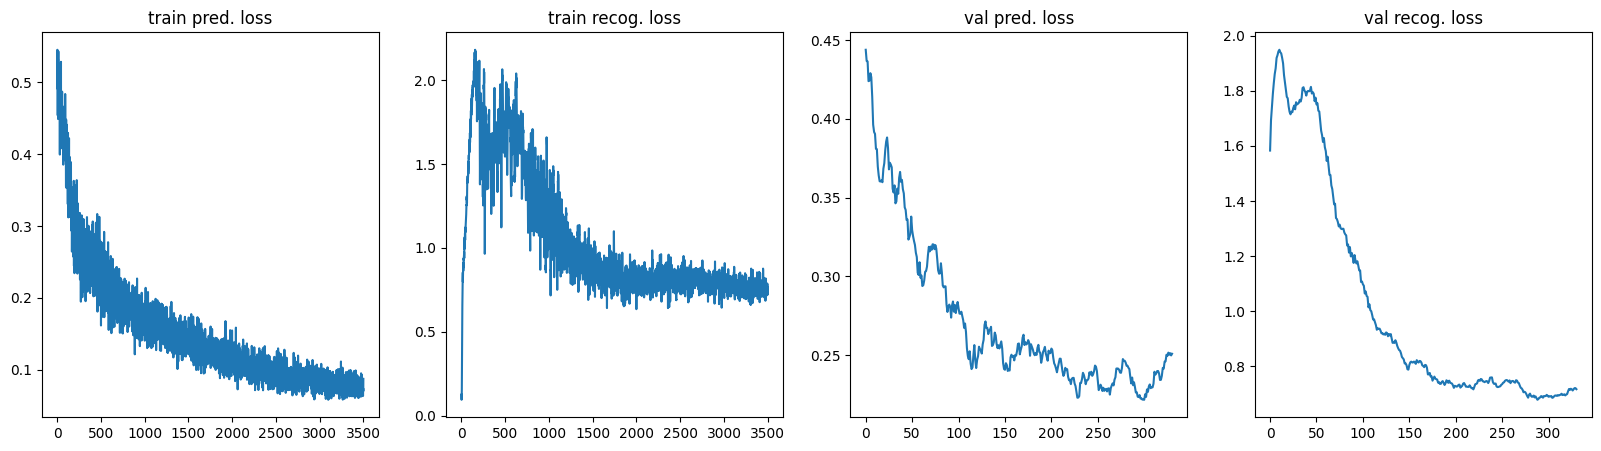

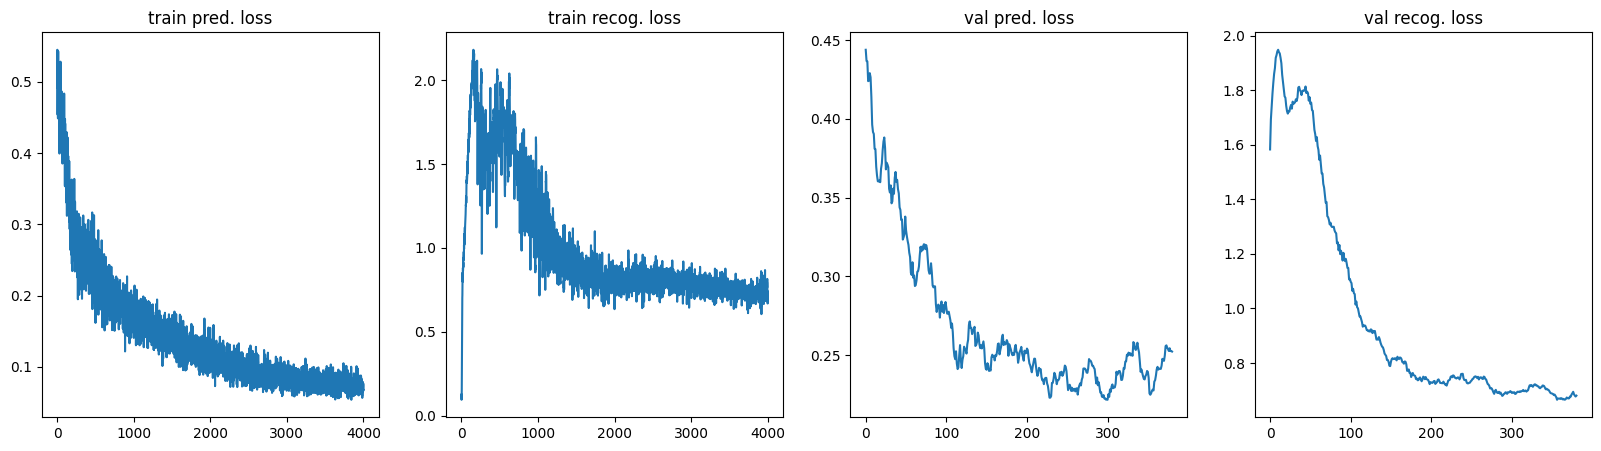

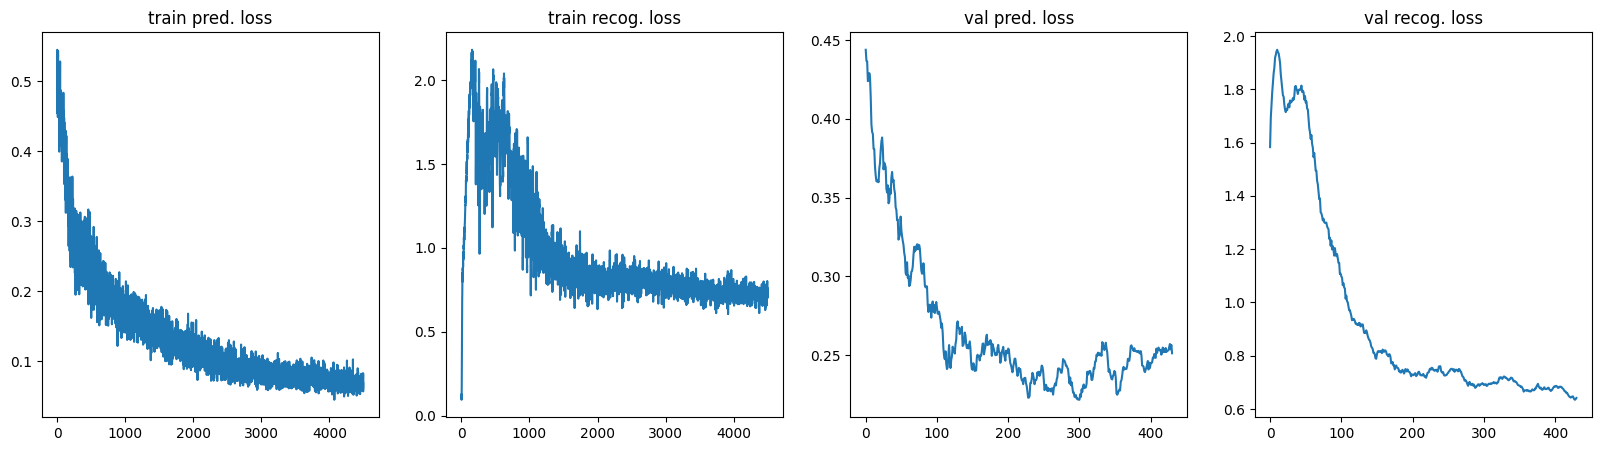

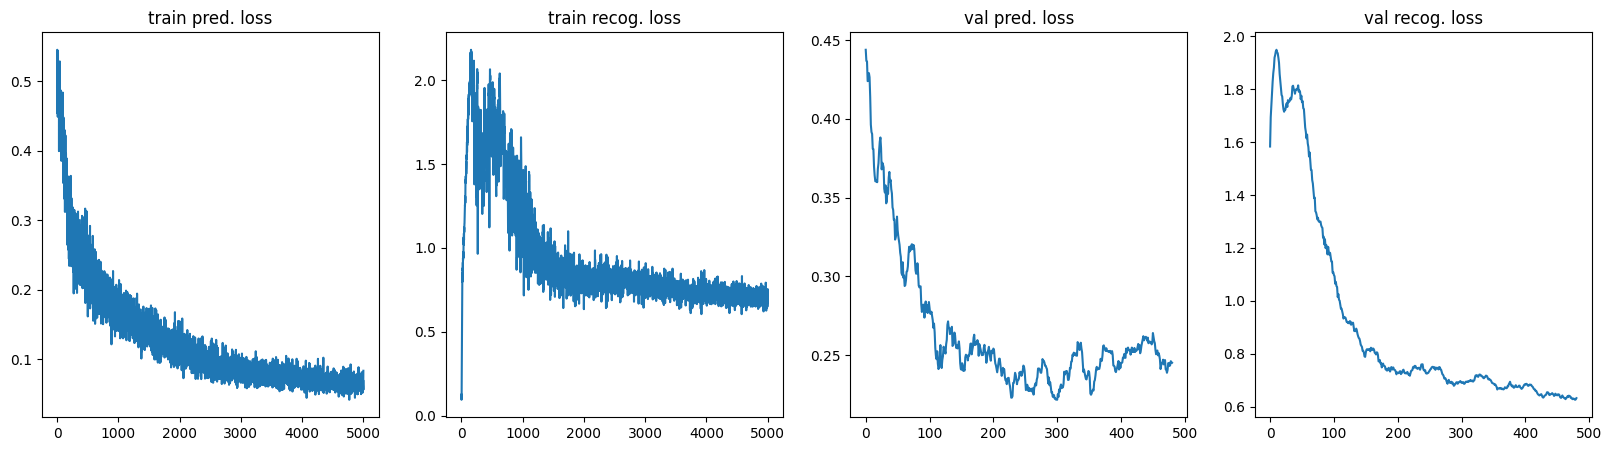

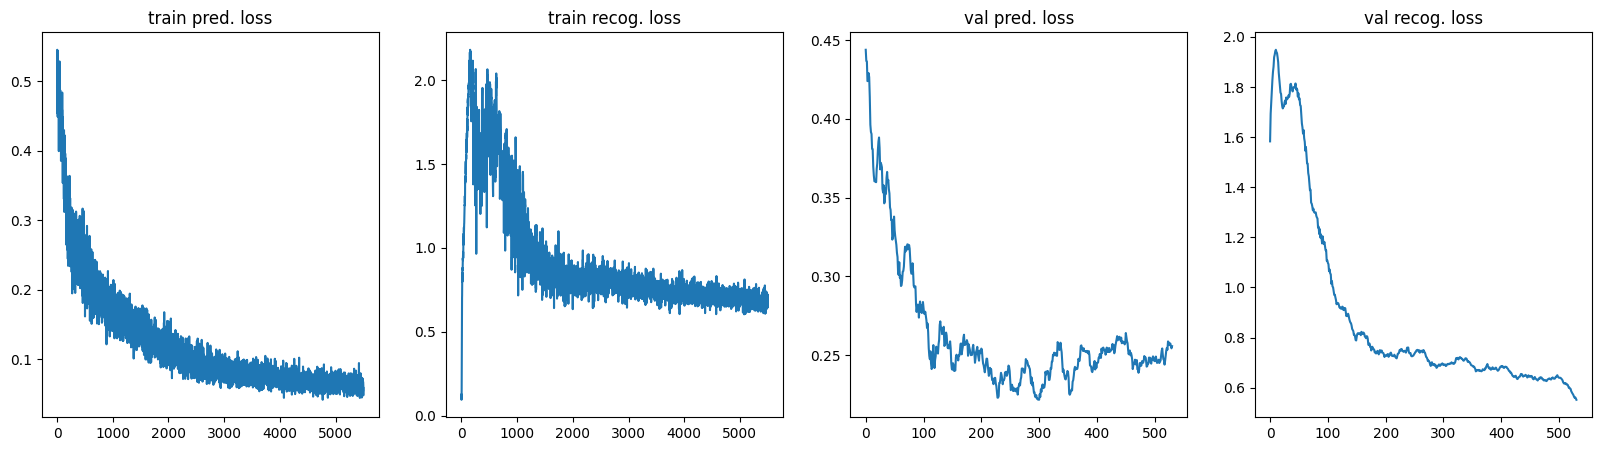

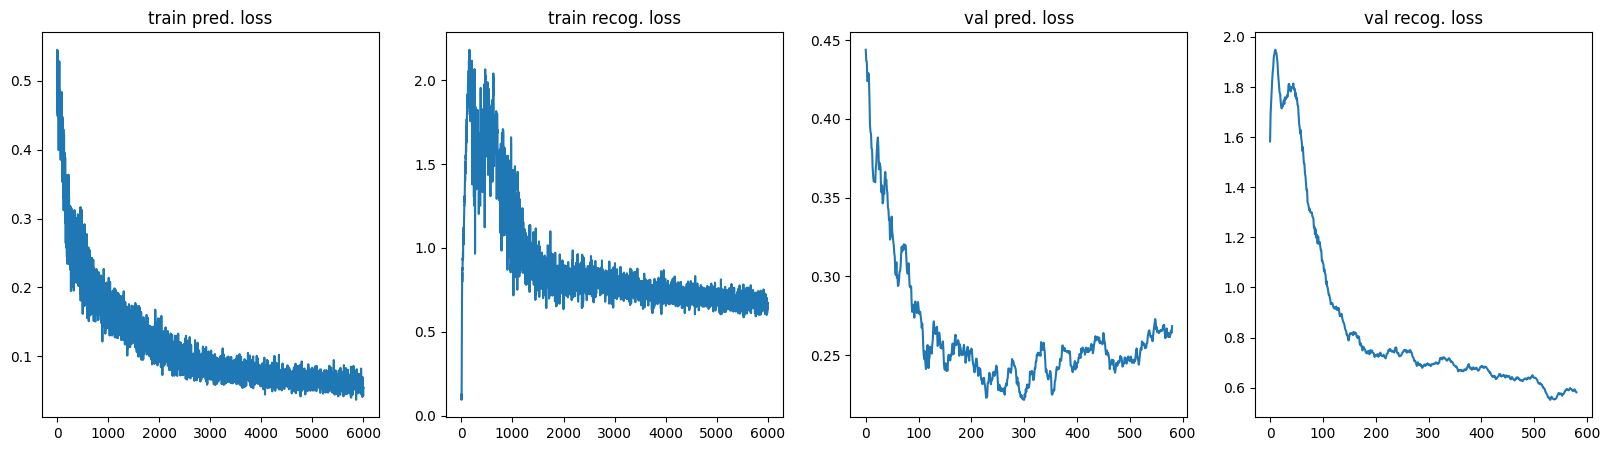

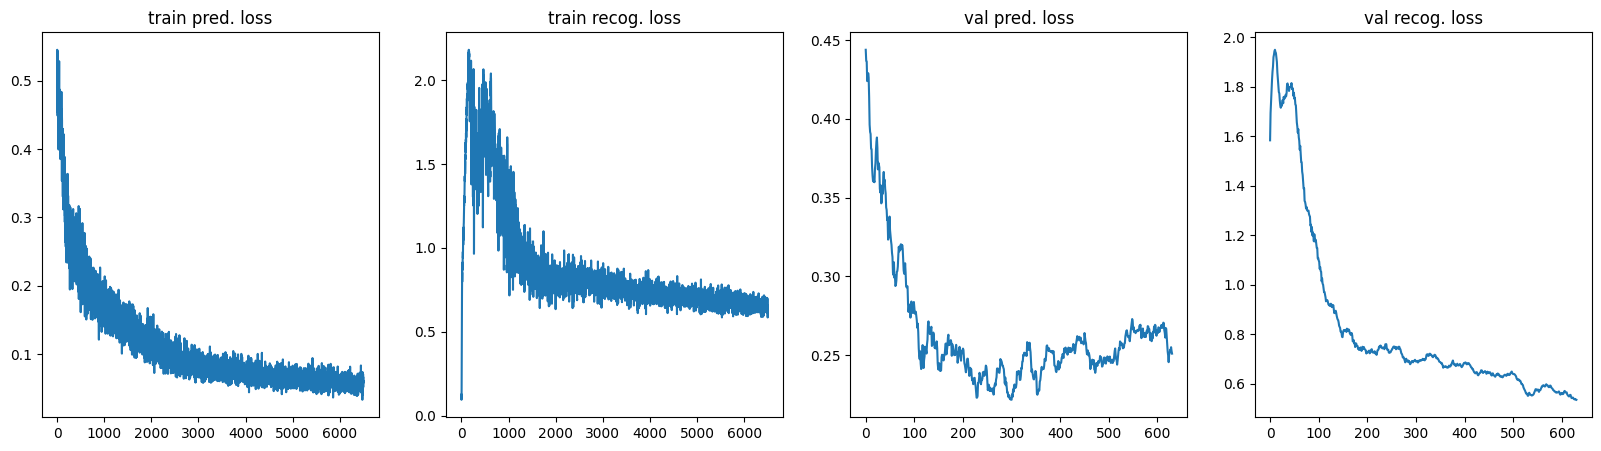

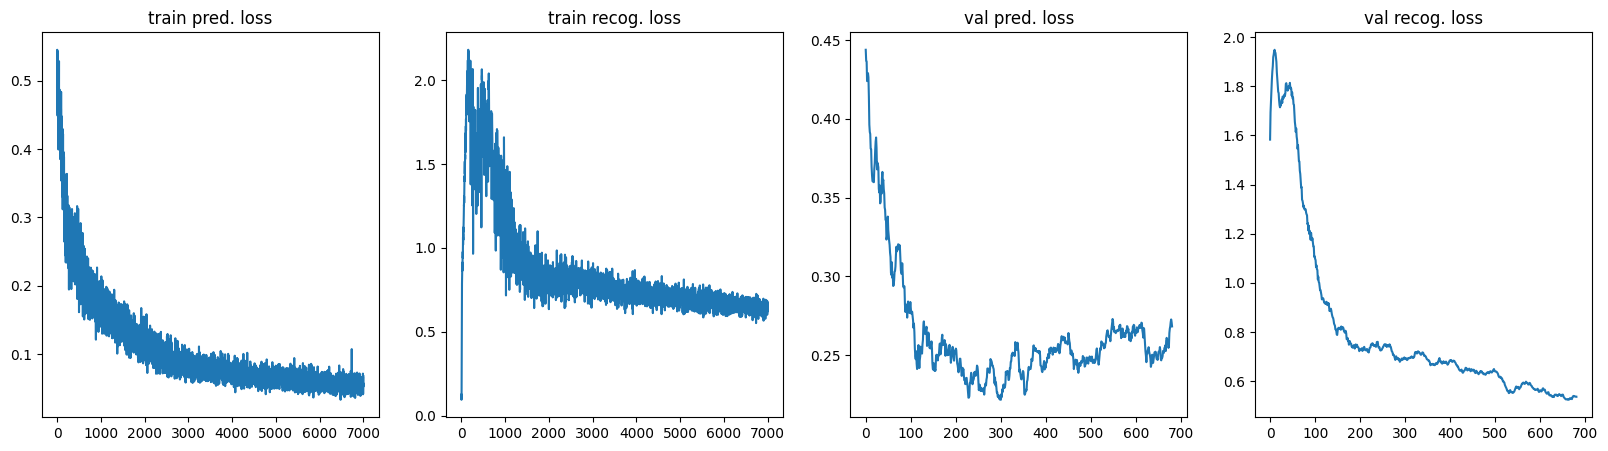

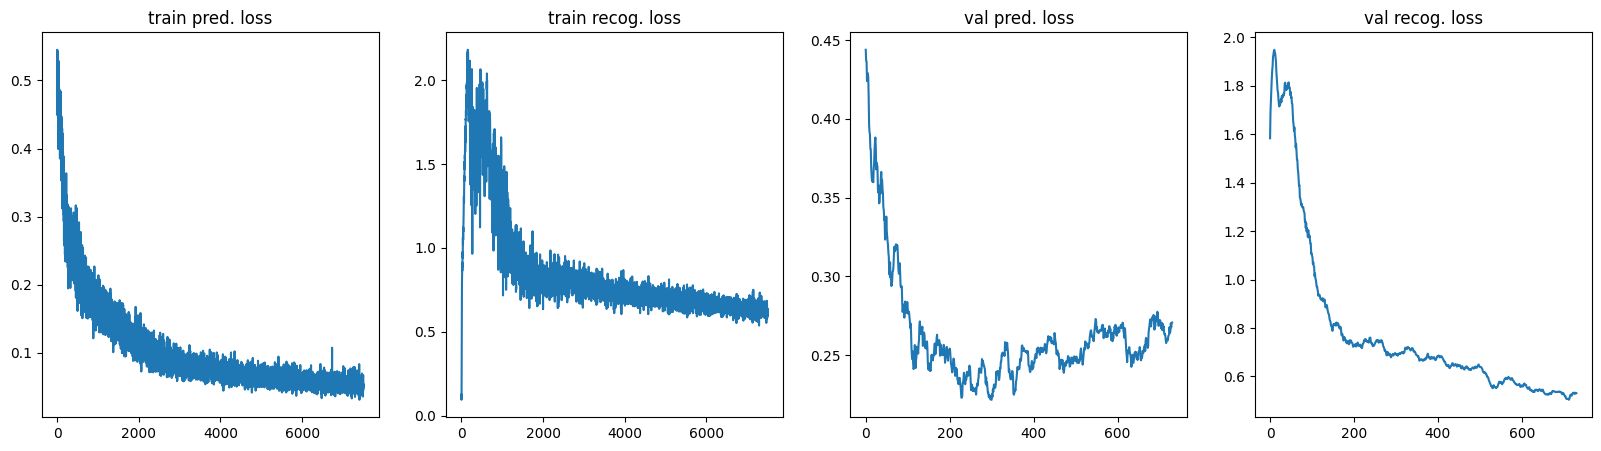

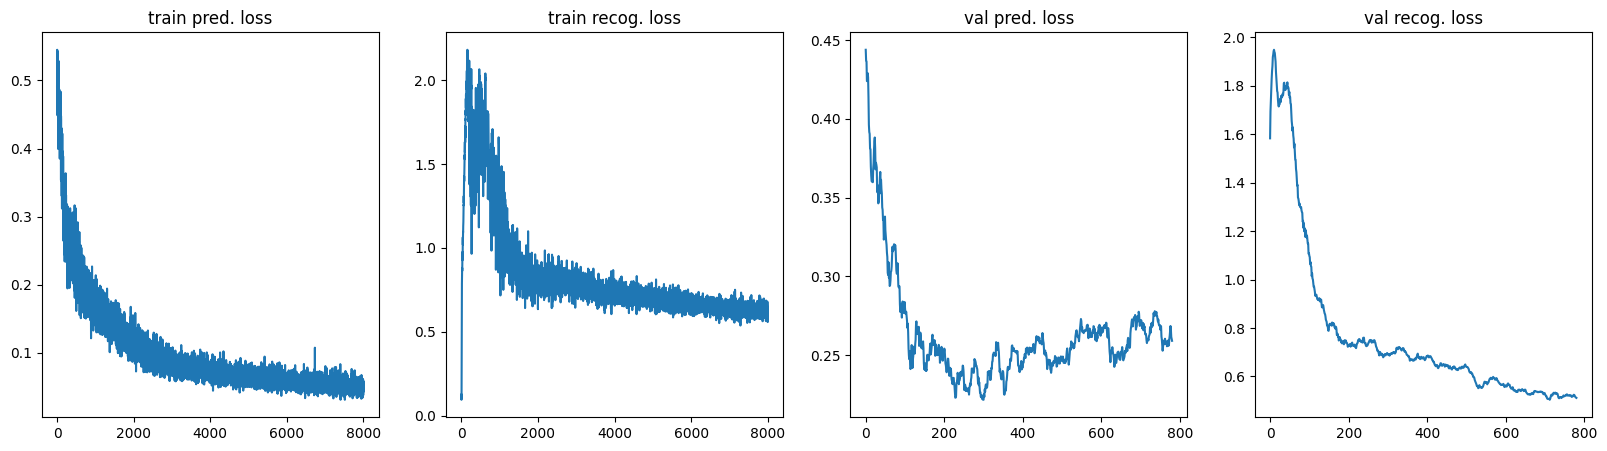

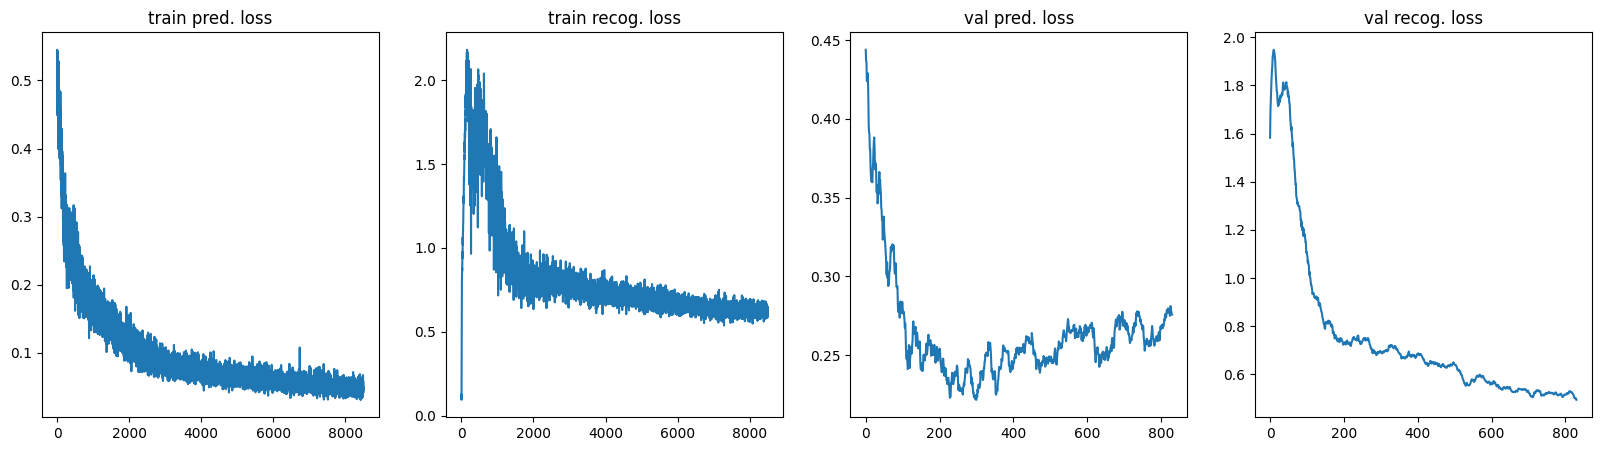

KeyboardInterrupt: 

In [13]:
#BASELINE: WITHOUT THE RECOGNITION NETWORK, LARGE NUMBER OF CELLS
figsize(20,5)
n_mod = 5
binmod = BinModLinear(n_mod = n_mod,samp_max = 120).cuda()
conv = nn.Sequential(nn.Dropout(0.5),nn.Conv1d(384,512,20,5), nn.ReLU(), nn.MaxPool1d(2),nn.Conv1d(512,20,10),nn.ReLU(), nn.Flatten(),nn.Linear(180,n_mod)).cuda()

optim = torch.optim.AdamW(list(binmod.parameters()) + list(conv.parameters()), lr = 1e-4,weight_decay = 0.0001)

loss_history = []
val_loss_history = []
spred_loss_history = []
val_s_history = []


for i in tqdm(range(200000)):
    targets = ytr[np.random.choice(np.arange(ytr.shape[0]),size = ytr.shape[0])] + 0.05*torch.rand_like(ytr)
    targets/=targets.sum(axis = 1,keepdims = True)
    dists = (torch.abs(ytr-targets)).sum(axis = 1)
    pred,q = binmod.forward(train,targets)
    
    loss = torch.abs(dists - pred ).mean()    
    
    spred = conv.forward(seq_tr)
    spredloss = torch.square(spred -q ).sum(axis = 1).mean()
    
    
    optim.zero_grad()
    (loss + 0*spredloss).backward()
    optim.step()
    loss_history.append(loss.detach().cpu().numpy())
    spred_loss_history.append(spredloss.detach().cpu().numpy())
    
    if i%10==0:
        val_targets = yval[np.random.choice(np.arange(yval.shape[0]),size = yval.shape[0])]
        binmod.eval()
        conv.eval()
        val_pred,val_q = binmod.forward(val,val_targets)
        val_s_loss = torch.square(val_q - conv(seq_val)).sum(axis = 1).mean()
        val_dists = (torch.abs(yval-val_targets)).sum(axis = 1)
        val_loss = torch.abs(val_pred-val_dists).mean()
        val_loss_history.append(val_loss.detach().cpu().numpy())
        val_s_history.append(val_s_loss.detach().cpu().numpy())
        conv.train()
        binmod.train()

    if (i+1) %500 ==0:
        plt.subplot(1,4,1)
        plt.plot(loss_history)
        plt.title('train pred. loss')
        plt.subplot(1,4,2)
        plt.plot(spred_loss_history)
        plt.title('train recog. loss')
        plt.subplot(1,4,3)
        plt.plot(moving_average(val_loss_history,20))
        plt.title('val pred. loss')
        plt.subplot(1,4,4)
        plt.plot(moving_average(val_s_history,20))
        plt.title('val recog. loss')

        plt.show()
torch.save(binmod.state_dict(), 'topcoder_baseline_state_dict')        


In [ ]:
# genes = pd.read_table('../data/seq/mouse/refGene.gtf',header = None)
# transcripts = genes[genes[2]=='transcript']
# transcripts['id'] =[a.split(';')[0].split(' ')[-1][1:-1] for a in transcripts[8]]
# data = transcripts[[0,3,4,6,'id']].drop_duplicates()
# data.columns = ['chrom', 'start', 'stop', 'strand', 'gene_symbol']
# data['tss'] = [data['start'].iloc[i] if (s== '+') else data['stop'].iloc[i] for i,s in enumerate(data['strand'])]
# data = data[data['gene_symbol'].isin(gene_names)].groupby('gene_symbol').apply(lambda x: x.iloc[0]).sort_values(['chrom','tss'])


# data = data.sort_values(['chrom','tss'])
# chrs = {chrom:data.loc[val] for chrom,val in data.groupby('chrom').groups.items()}
# chroms = sorted(set(data['chrom']))
# output_features = {}
# good_tss = {}
# either_side = 100
# for chrom in tqdm(chroms):
#     chr_dat = np.load('../data/seq/mouse/precomputed/{}_precomputed_features_512.npy'.format(chrom), mmap_mode = 'r')
#     chr_pos = np.load('../data/seq/mouse/precomputed/{}_CHROM_positions_512.npy'.format(chrom))
#     good_tss[chrom] = chrs[chrom][(chrs[chrom]['tss']+32*either_side)<chr_pos.max()]
#     selected_inds = np.searchsorted(chr_pos, good_tss[chrom]['tss'])-either_side
#     sliding = sliding_window_view(chr_dat,(2*either_side,384))
#     output_features[chrom] = sliding[selected_inds]
    
# seq_batch = torch.cat([torch.from_numpy(output_features[chrom][:,0,:,:]).cuda().float() for chrom in good_tss.keys()], 0).permute(0,2,1)
# ind_key = {k:i for i,k in enumerate(data.index.values)}
# seq_tr = seq_batch[[ind_key[g] for g in train]]
# seq_val = seq_batch[[ind_key[g] for g in val]]
# seq_test = seq_batch[[ind_key[g] for g in test]]

# np.save('topcoder_gene_seq_features.npy', seq_batch.cpu().detach().numpy().astype(np.float32))
# np.save('topcoder_gene_names',data.index.values.astype(str))